In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import graphviz
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

Load data.

In [3]:
all = pd.read_csv('input/hour.csv', header=0)

Simple statistics about dataset.

In [4]:
all.shape

(17379, 17)

In [5]:
all.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [6]:
all.isnull().values.any()

False

17 Columns, 17379 samples. Mostly float and integer datatypes, only dteday is string. No NAs.

Some preliminary feature engineering. Extract the day of the month. Convert date into a number.

In [7]:
all.insert(5,'day',0)
all['day'] = all['dteday'].str[-2:].astype(int)
all['dteday'] = all['dteday'].astype('category').cat.codes

Obtain the original non-normalized values.

In [8]:
all['temp'] = (all['temp']*41).round(3)
all['atemp'] = (all['atemp']*50).round(3)
all['hum'] = (all['hum']*100).astype(int)
all['windspeed'] = (all['windspeed']*67).astype(int)

Feature lists.

In [10]:
ft = [col for col in all.columns.values if col not in ['instant','casual','registered','cnt']]
ft_weather = ['weathersit', 'temp', 'atemp', 'hum', 'windspeed']
ft_time = ['season', 'yr', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday']

Target statistics.

In [9]:
all['cnt'].describe()[['min','max','mean','std']]

min       1.000000
max     977.000000
mean    189.463088
std     181.387599
Name: cnt, dtype: float64

Target variable visualisation.

<Figure size 432x288 with 0 Axes>

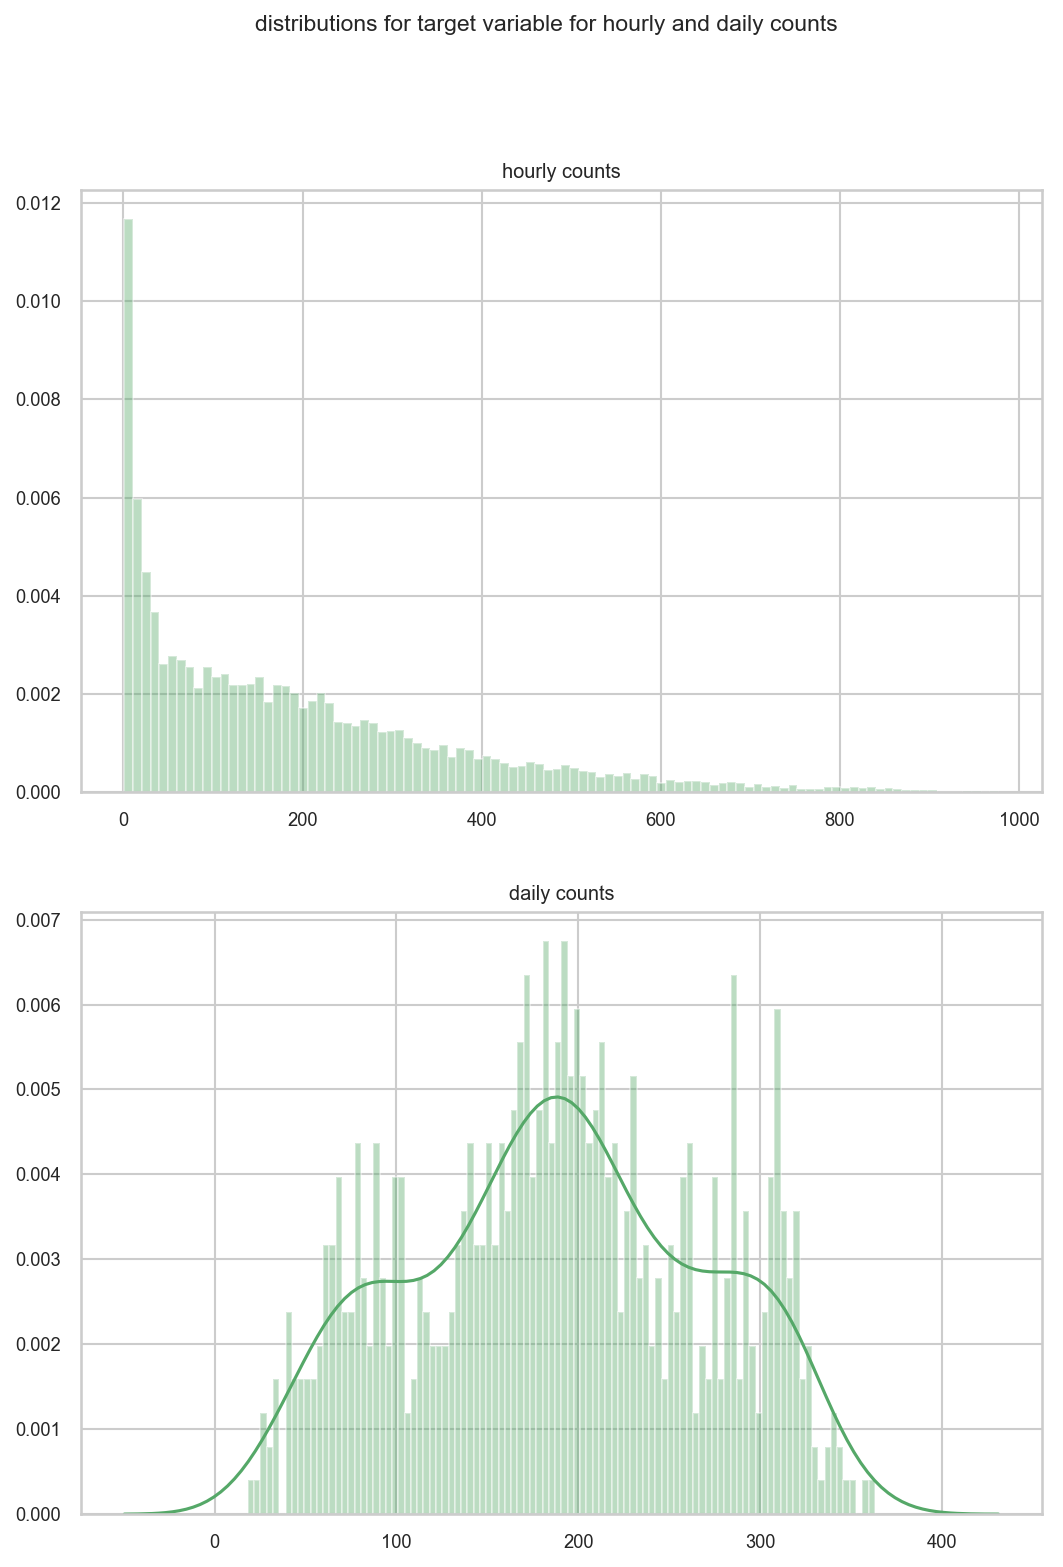

In [11]:
pp = PdfPages('target_counts.pdf')
plt.tight_layout()
sns.set(font_scale = 0.8)
sns.set_style('whitegrid')
plt.figure(figsize=(8.27, 11.69),dpi=150)
plt.suptitle('distributions for target variable for hourly and daily counts', fontsize=11)
plt.subplot(2, 1, 1)
plt.title('hourly counts')
sns.distplot(all['cnt'], axlabel = False, color = 'g', bins = 100, kde = False, norm_hist= True)
plt.subplot(2, 1, 2)
plt.title('daily counts')
sns.distplot(all.groupby('dteday')['cnt'].mean(), axlabel = False, color = 'g', bins = 100, kde = True, norm_hist= True)
pp.savefig()

# for j in range(1,5):
#     plt.figure(figsize=(30,40))
#     plt.suptitle('target variable counts for hourly and daily counts: season %d'%j, fontsize=24)
#     plt.subplot(2, 1, 1)
#     plt.title('hourly counts')
#     sns.distplot(all.loc[all['season'] == j, 'cnt'], axlabel = False, color = 'g', bins = 100, kde = False, norm_hist= True)
#     plt.subplot(2, 1, 2)
#     plt.title('daily counts')
#     sns.distplot(all.loc[all['season'] == j].groupby('dteday')['cnt'].mean(), axlabel = False, color = 'g', bins = 50, kde = True, norm_hist= True)
#     pp.savefig()

pp.close()

Check value counts and distributions for weather conditions.

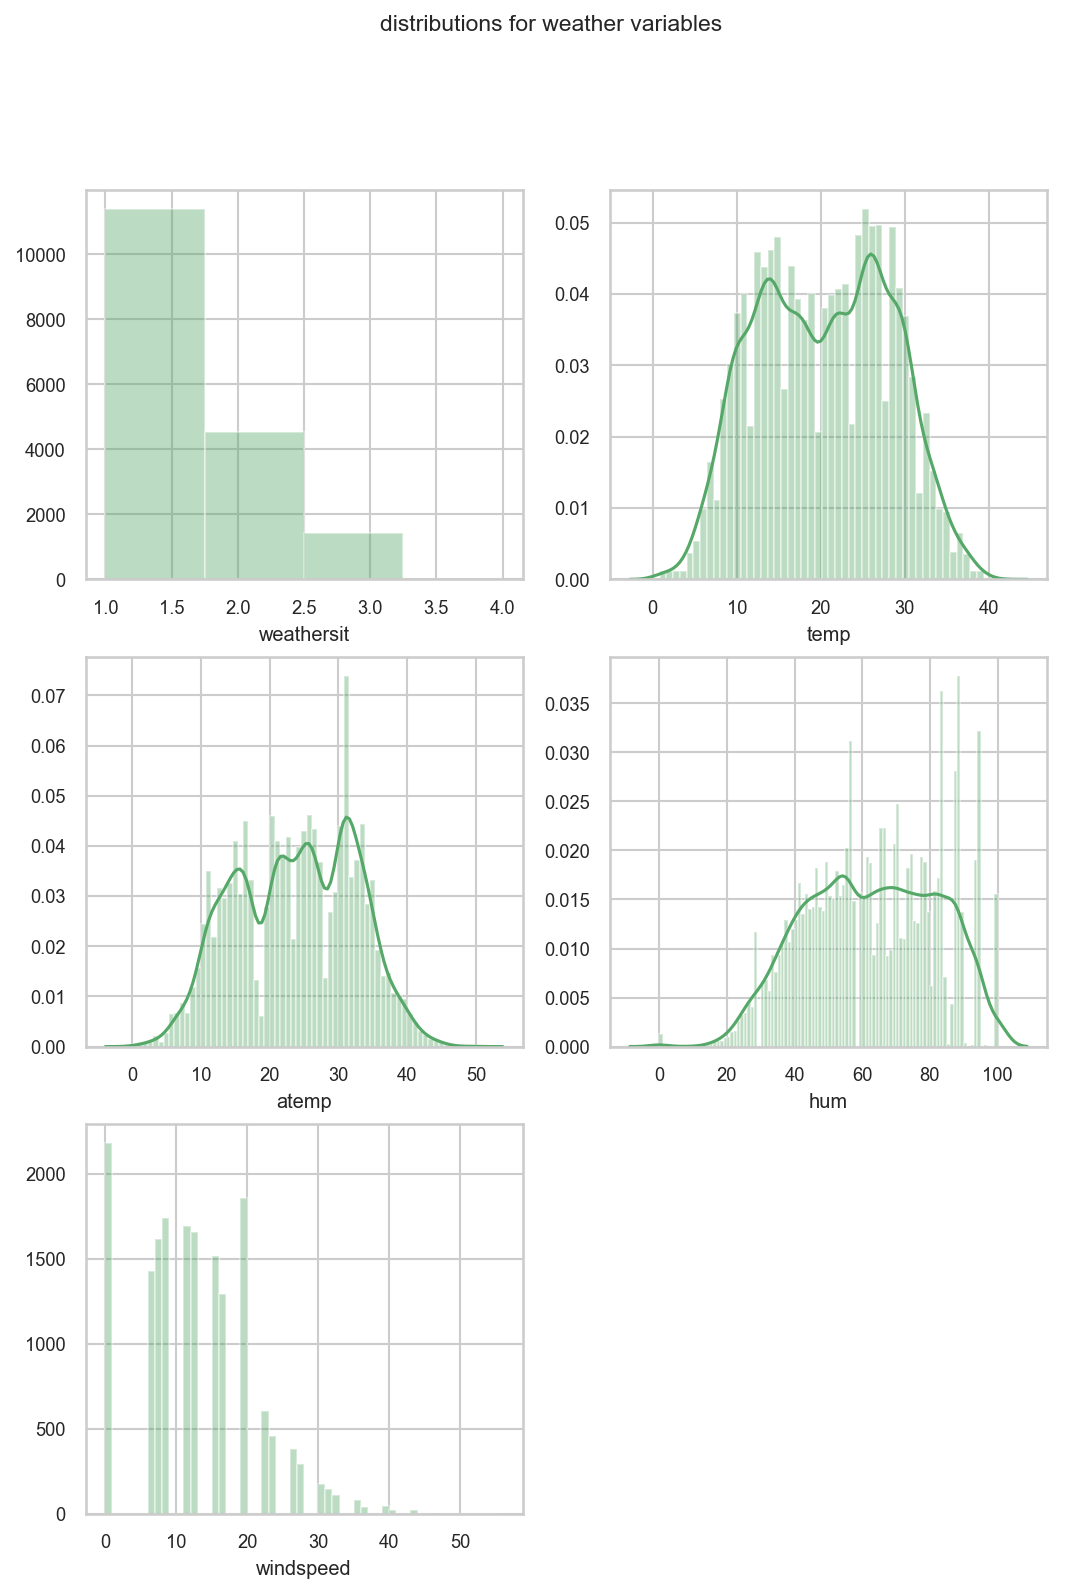

In [12]:
pp = PdfPages('weather_counts.pdf')
sns.set(font_scale = 0.8)
sns.set_style('whitegrid')

plt.figure(figsize=(8.27, 11.69),dpi=150)
plt.suptitle('distributions for weather variables', fontsize=11)
for i, col in enumerate(ft_weather):
    bin_count = max(int(all[col].max()), all[col].nunique())
    plt.subplot(3, 2, 1+i)
    sns.distplot(all[col], axlabel = col, color = 'g', bins = bin_count, kde = col in ['temp', 'atemp', 'hum'], norm_hist= False)
pp.savefig()

# for j in range(1,5):
#     plt.figure(figsize=(30,40))
#     plt.suptitle('distributions for weather conditions: season %d'%j, fontsize=30)
#     for i, col in enumerate(ft_weather):
#         series = all.loc[all['season'] == j, col]
#         bin_count = max(int(series.max()), series.nunique())
#         plt.subplot(3, 2, 1+i)
#         sns.distplot(series, axlabel = col, color = 'g', bins = bin_count, kde = col in ['temp', 'atemp', 'hum'], norm_hist= False)
#     pp.savefig()
pp.close()

Target vs time variables.

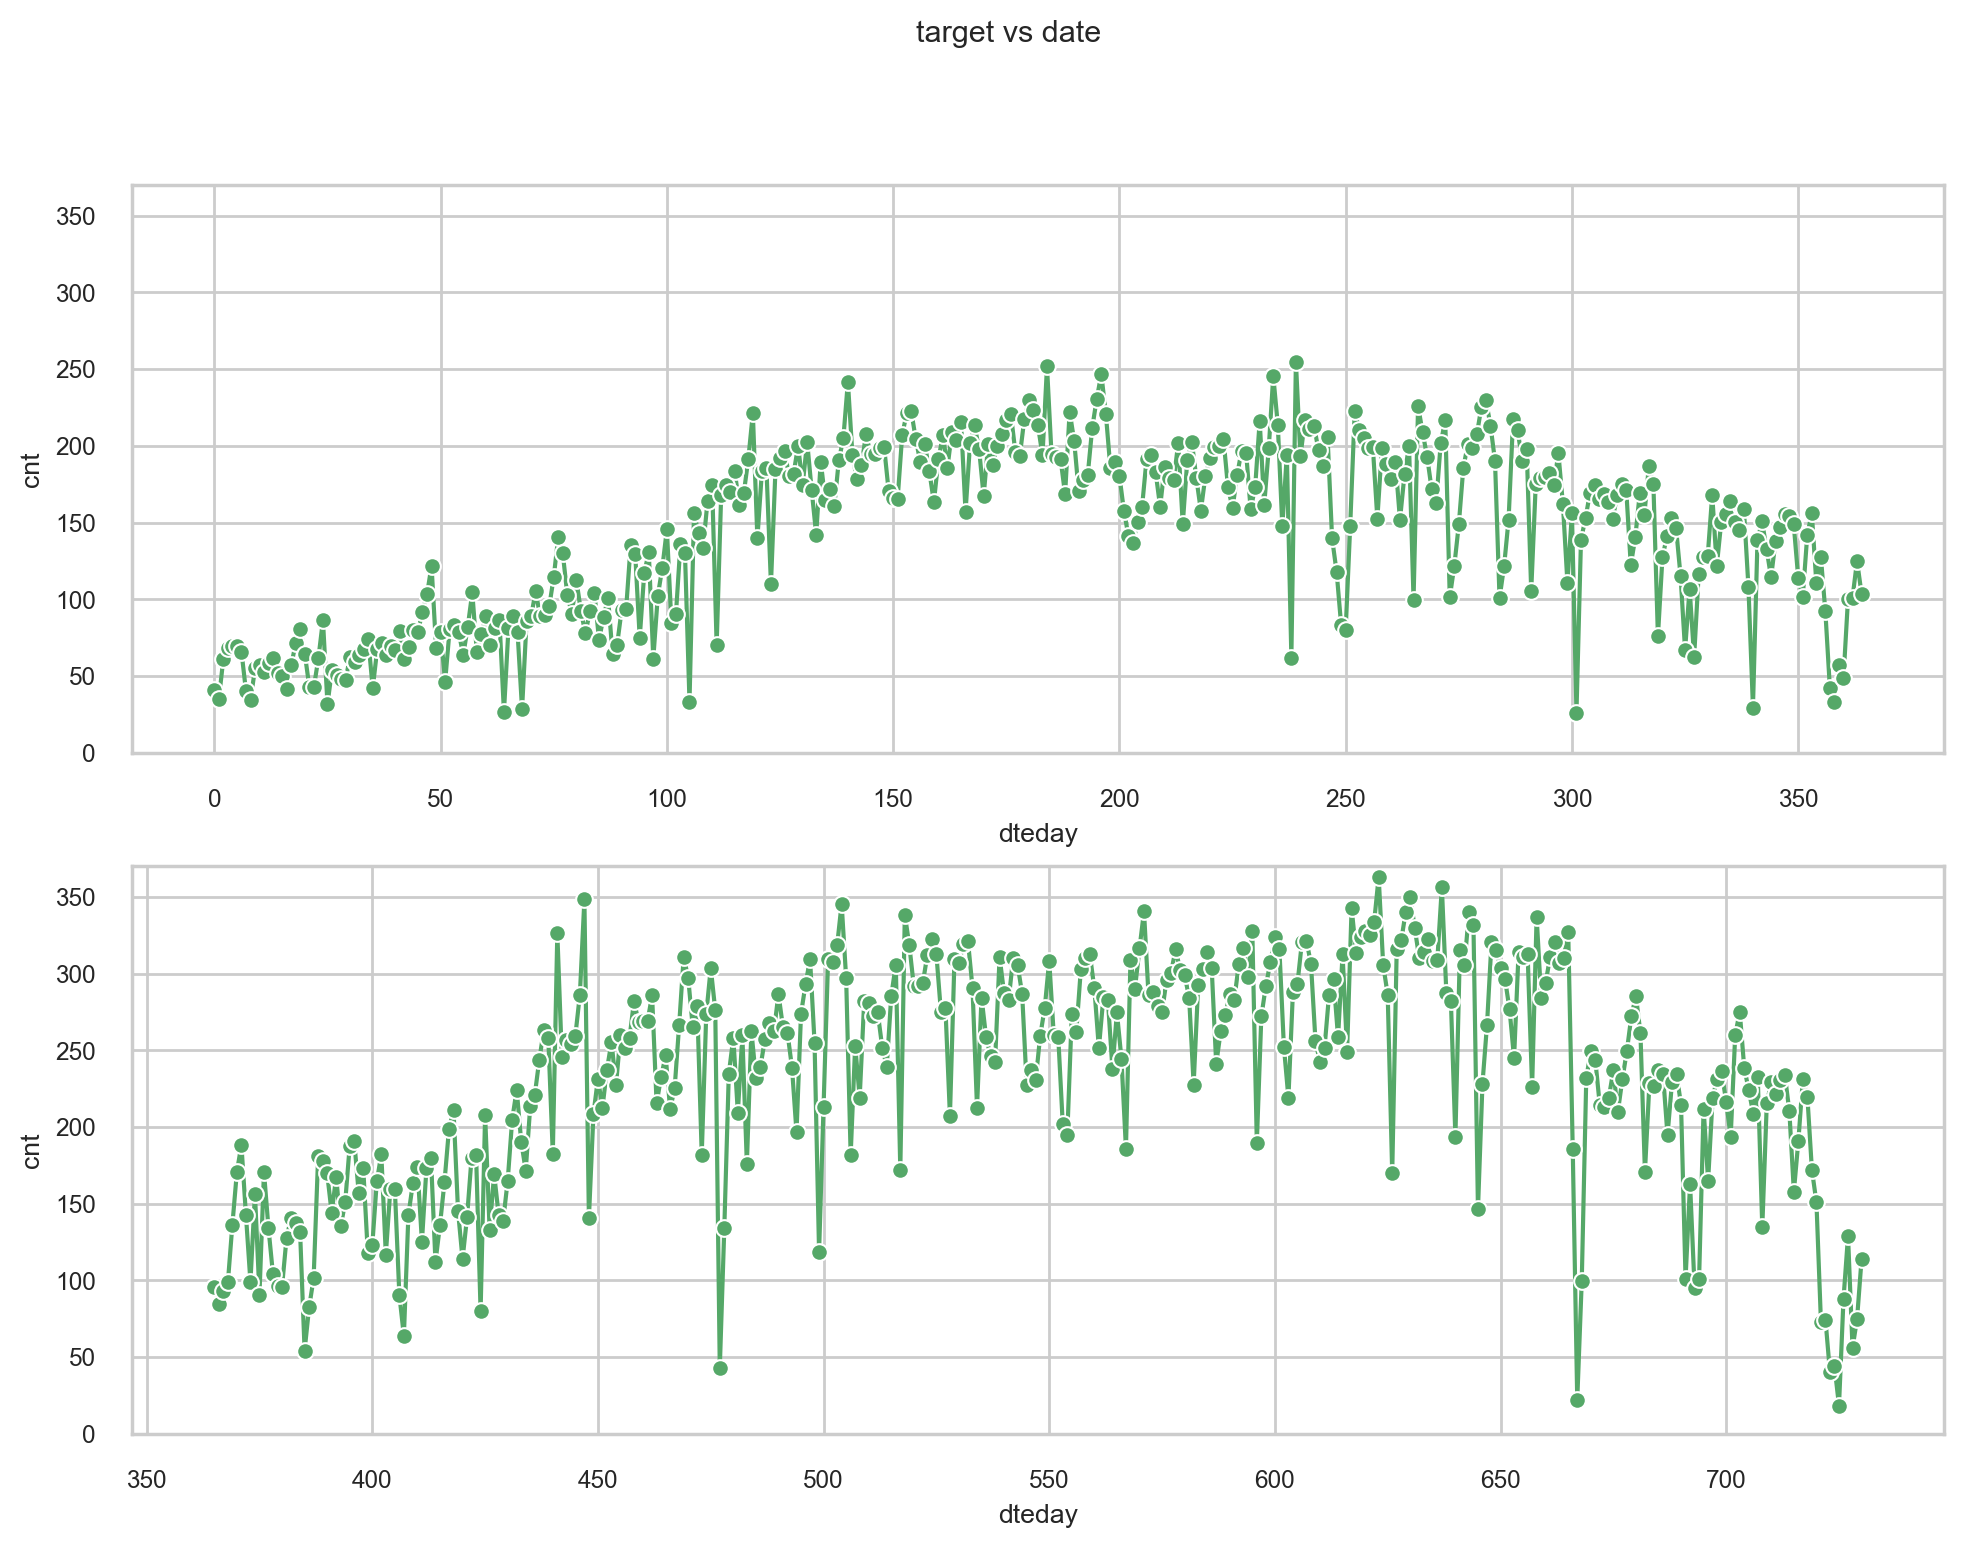

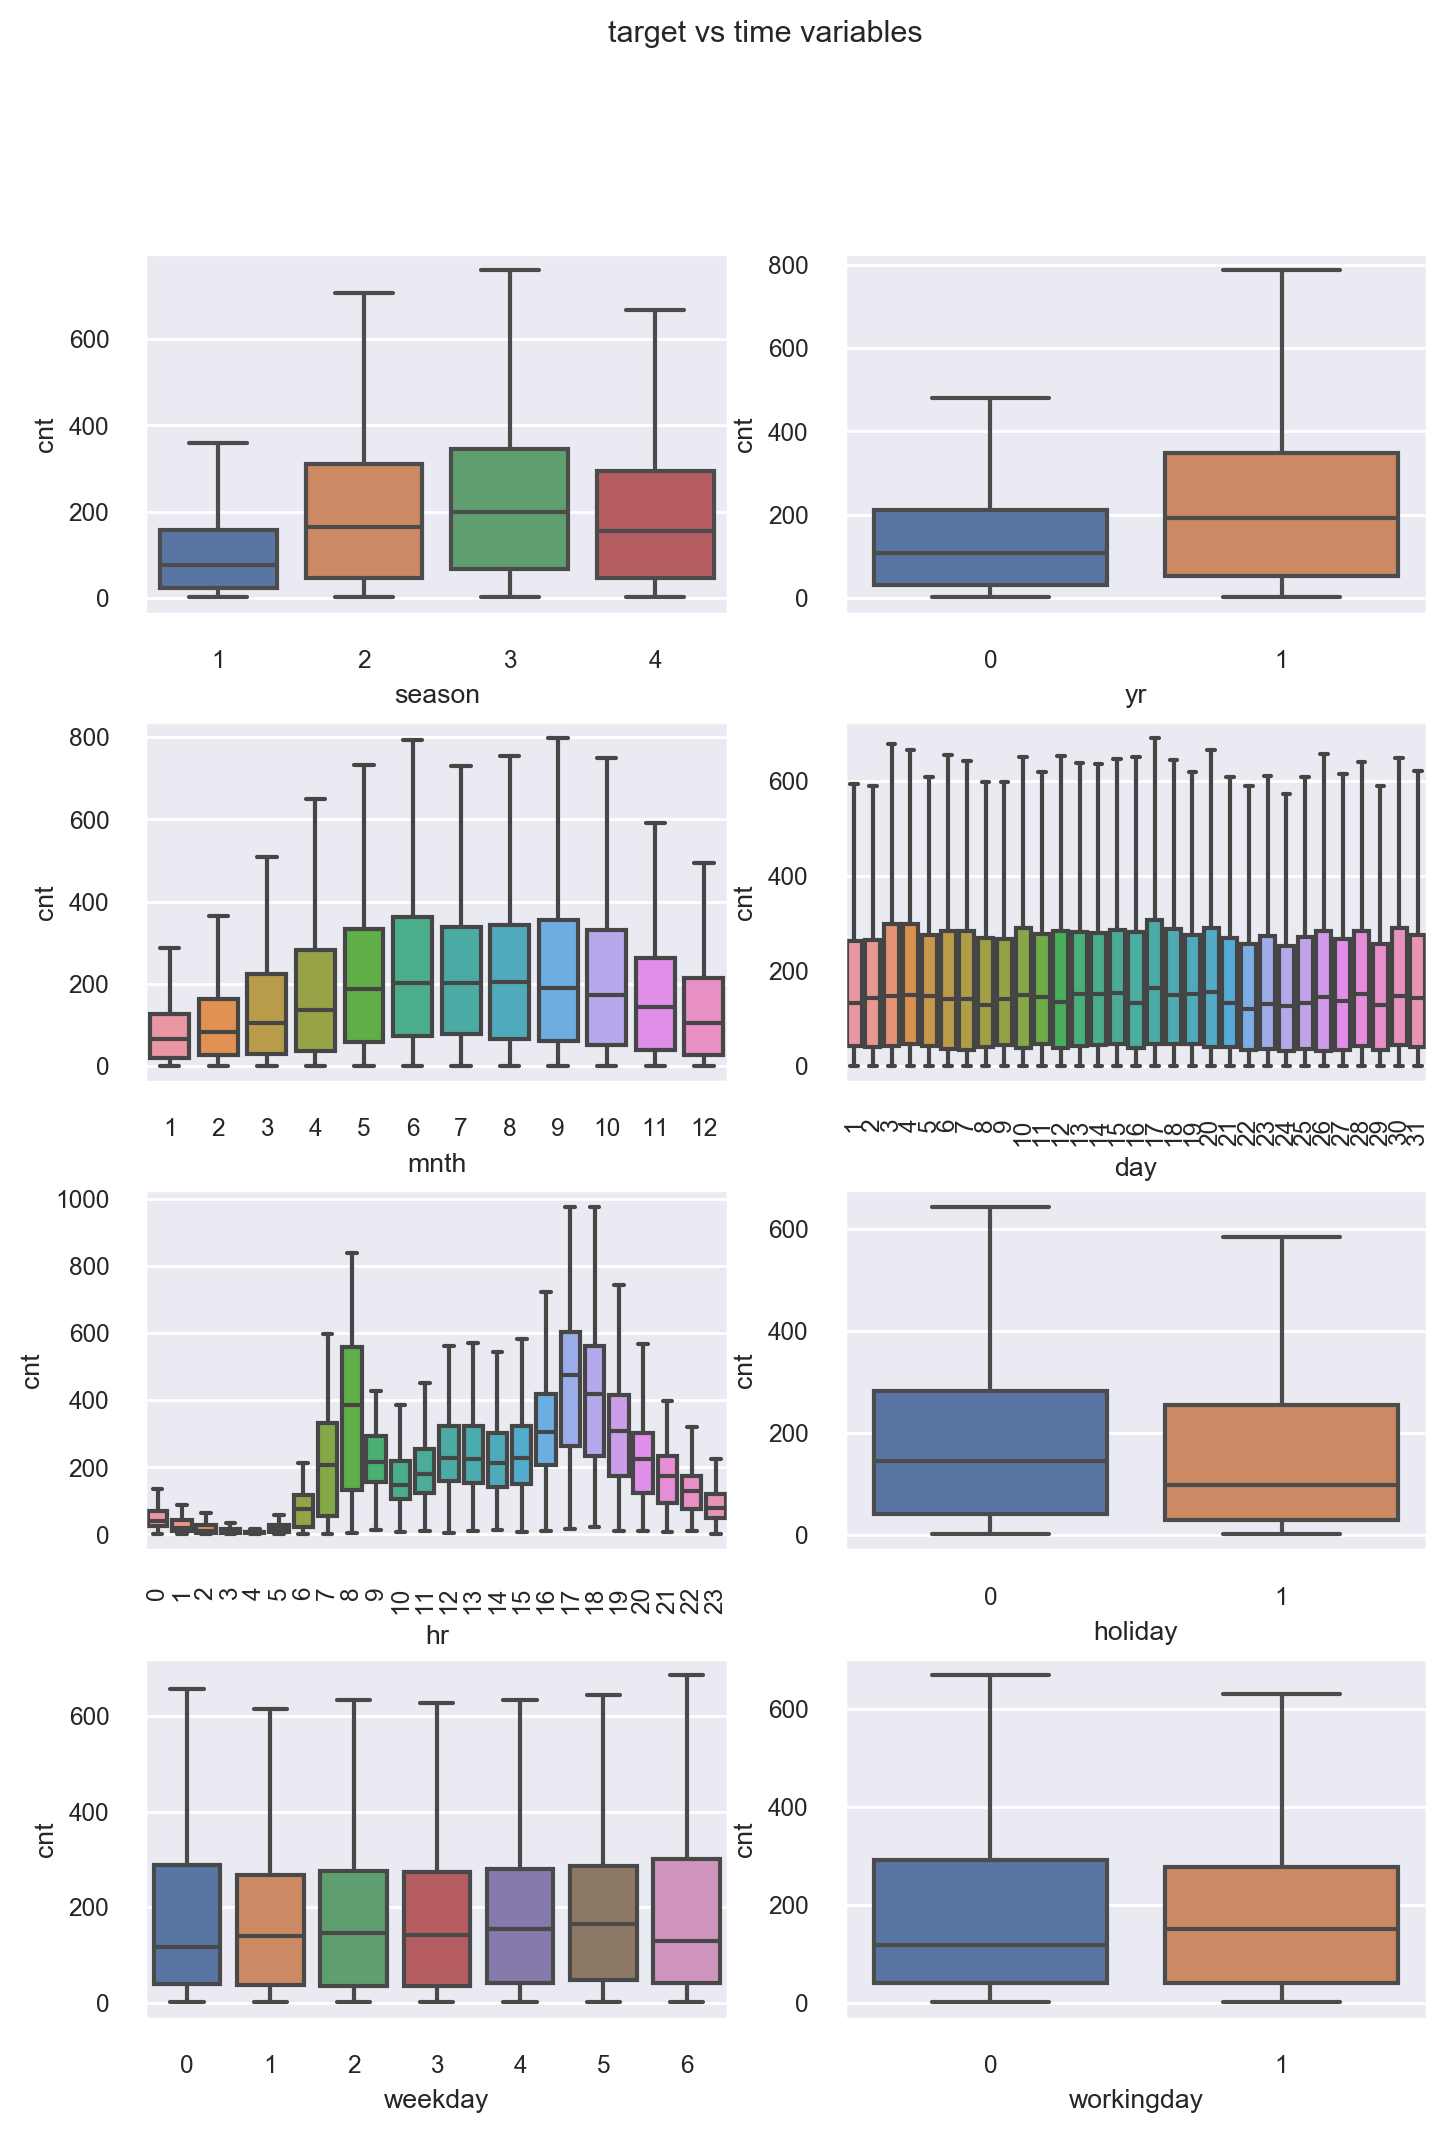

In [13]:
pp = PdfPages('target_vs_date.pdf')
plt.style.use('seaborn')
sns.set(font_scale = 0.8)
sns.set_style('whitegrid')

plt.figure(figsize=(11.69,8.27),dpi=200)
plt.suptitle('target vs date', fontsize=11)
for i in range(2):
    plt.subplot(2, 1, 1+i)
    plt.ylim(0, 370)
    sns.lineplot(x='dteday', y='cnt', data=all.loc[all['yr']==i],  ci=None, color='g', marker='o')
pp.savefig()
pp.close()

pp = PdfPages('target_vs_time.pdf')
sns.set(font_scale = 0.8)
plt.figure(figsize=(8.27,11.69),dpi=200)
plt.subplots_adjust(hspace = .3)
plt.suptitle('target vs time variables', fontsize=11)
for i, col in enumerate(ft_time):
    plt.subplot(4, 2, 1+i)
    sns.boxplot(x=col, y='cnt', data=all, showfliers = False)
    if col in ['day','hr']: plt.xticks(rotation=90)
pp.savefig()

pp.close()

Target vs weather variables.

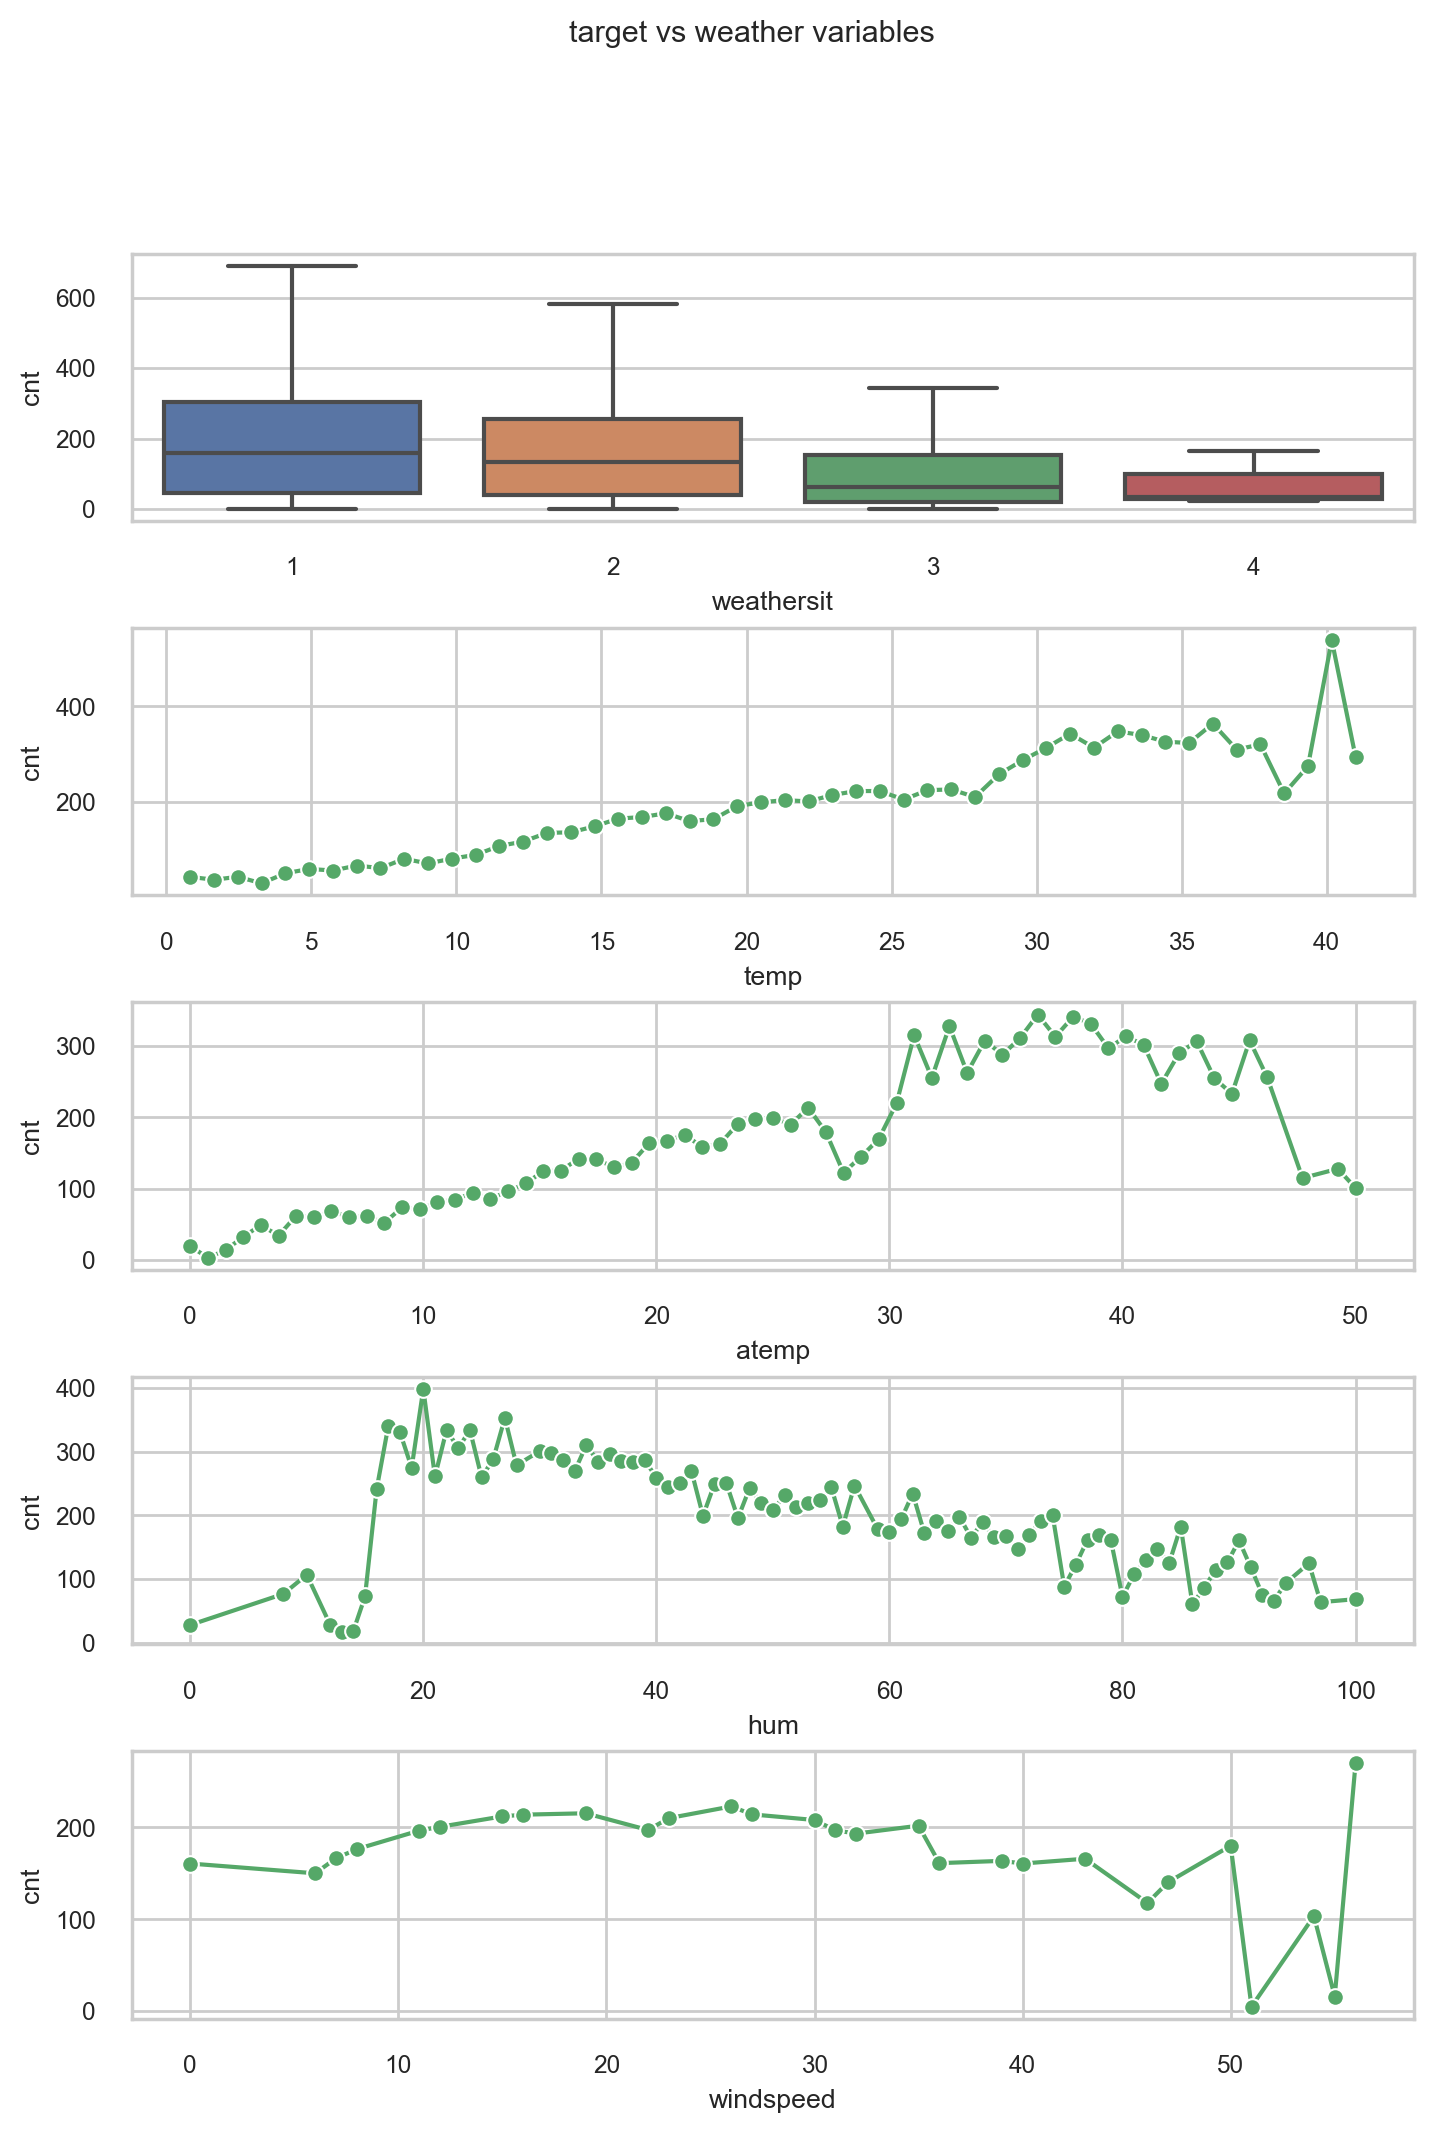

In [14]:
pp = PdfPages('target_vs_weather.pdf')
plt.style.use('seaborn')
sns.set(font_scale = 0.8)
sns.set_style('whitegrid')

plt.figure(figsize=(8.27,11.69),dpi=200)
plt.subplots_adjust(hspace = .4)
plt.suptitle('target vs weather variables', fontsize=11)
plt.subplot(5, 1, 1)
sns.boxplot(x='weathersit', y='cnt', data=all, showfliers = False)
for i, col in enumerate([col for col in ft_weather if col not in ['weathersit']]):
    plt.subplot(5, 1, 2+i)
    sns.lineplot(x=col, y='cnt', data=all, ci=None, color='g', marker='o')
pp.savefig()

pp.close()

Correlations.

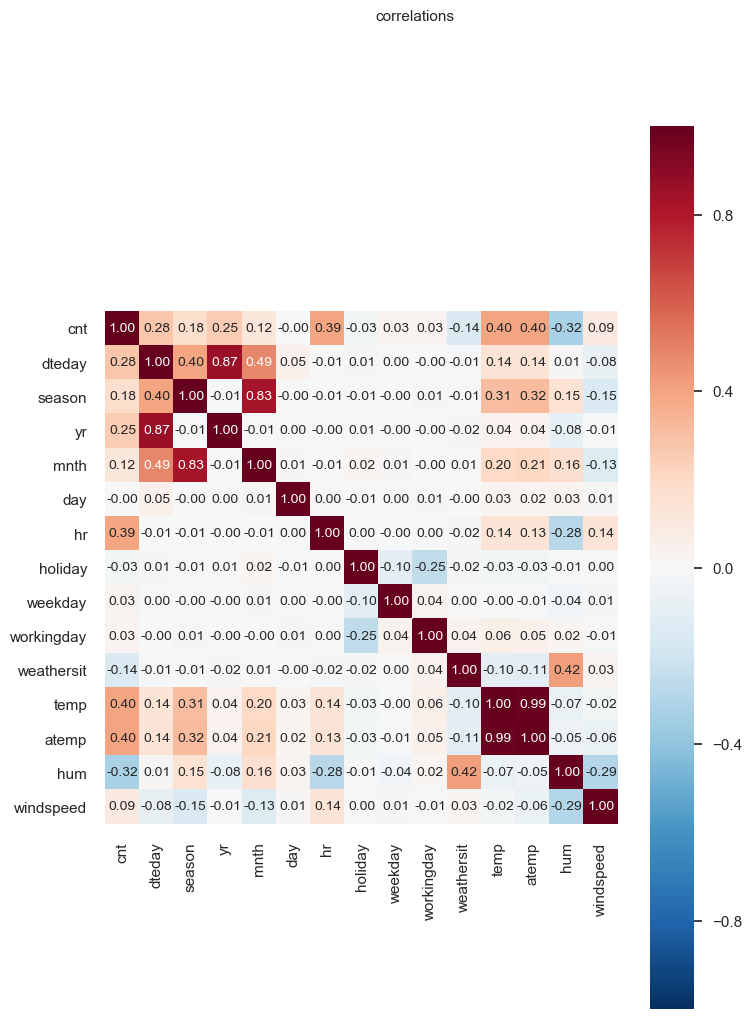

In [15]:
pp = PdfPages('correlations.pdf')
cols = ['cnt'] + ft
corr_mat = all[ft +['cnt']].corr(method='pearson')
cm = np.corrcoef(all[cols].values.T)
sns.set(font_scale=1)
plt.figure(figsize=(8.27,11.69),dpi=100)
plt.suptitle('correlations', fontsize=11)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', cmap='RdBu_r', vmin=-1, vmax=1,
                 annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)
pp.savefig()
pp.close()